### Notebook for running SCOT on SNARE-seq Cell Mixture Data

**Access to the raw dataset:** Gene Expression Omnibus accession no. GSE126074. 
SNARE-seq data in `/data` folder containes the version with dimensionality reduction techniques applied from the original SNARE-seq paper (https://www.nature.com/articles/s41587-019-0290-0). Namely, PCA for gene expression (scRNA-seq) domain with 10 components, and LDA with 19 topics for chromatin accessibility (snATAC-seq) domain using cisTopic package in R. Below, we replicate our results for the SNARE-seq dataset reported in ["Gromov-Wasserstein optimal transport to align single-cell multi-omics data"](https://www.biorxiv.org/content/10.1101/2020.04.28.066787v2). 


If you have any questions, e-mail: ritambhara@brown.edu, pinar_demetci@brown.edu, rebecca_santorella@brown.edu  

In [1]:
import sys
sys.path.insert(1, '../src/')
from scot import *

In [2]:
X=np.load("../data/scatac_feat.npy") 
y=np.load("../data/scrna_feat.npy")
print("Dimensions of input datasets are: ", "X= ", X.shape, " y= ", y.shape)

Dimensions of input datasets are:  X=  (1047, 19)  y=  (1047, 10)


In [3]:
# initialize SCOT object
scot=SCOT(X, y)
# call the alignment with l2 normalization 
# A few hyperparameter combinations yield the best result (FOSCTTM ~0.149) and one of them is the following:
X_new, y_new = scot.align(k=110, e=1e-3,  normalize=True, norm="l2")

It.  |Err         
-------------------
    0|1.758021e-03|
   10|4.650066e-04|
   20|5.551472e-05|
   30|1.489434e-05|
   40|4.868141e-06|
   50|1.787543e-06|
   60|7.141842e-07|
   70|3.011861e-07|
   80|1.308225e-07|
   90|5.766123e-08|
  100|2.559230e-08|
  110|1.139643e-08|
  120|5.083008e-09|
  130|2.268915e-09|
  140|1.013200e-09|
  150|4.525532e-10|


##### Evaluate results:

In [4]:
import evals 

# We will use the average FOSCTTM measure implemented in evals.py for evaluation (metric used in the publication Demetci et al 2021)
# This measure reports the fraction of samples closer to a sample than its true match (FOSCTTM), averaged over all samples. 
fracs=evals.calc_domainAveraged_FOSCTTM(X_new, y_new)
print("Average FOSCTTM score for this alignment with X onto Y is: ", np.mean(fracs))

Average FOSCTTM score for this alignment with X onto Y is:  0.14963585296056656


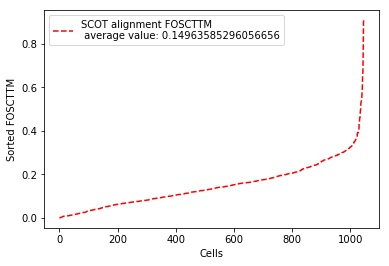

In [5]:
#Plotting sorted FOSCTTM to show the distributions of FOSCTTM across cells:

import matplotlib.pyplot as plt
legend_label="SCOT alignment FOSCTTM \n average value: "+str(np.mean(fracs)) #Put average FOSCTTM in the legend
plt.plot(np.arange(len(fracs)), np.sort(fracs), "r--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

##### Visualize Projections

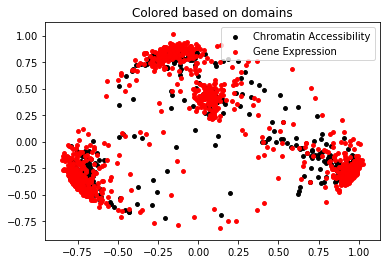

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Reduce the dimensionality of the aligned domains to two (2D) via PCA for the sake of visualization:
pca=PCA(n_components=2)
Xy_pca=pca.fit_transform(np.concatenate((X_new, y_new), axis=0))
X_pca=Xy_pca[0: 1047,]
y_pca=Xy_pca[1047:,]

#Plot aligned domains, samples colored by domain identity:
plt.scatter(X_pca[:,0], X_pca[:,1], c="k", s=15, label="Chromatin Accessibility")
plt.scatter(y_pca[:,0], y_pca[:,1], c="r", s=15, label="Gene Expression")
plt.legend()
plt.title("Colored based on domains")
plt.show()

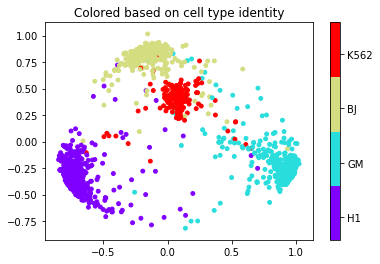

In [7]:
#Plot aligned domains, samples colored by cell types:
cellTypes_atac=np.loadtxt("../data/SNAREseq_atac_types.txt")
cellTypes_rna=np.loadtxt("../data/SNAREseq_rna_types.txt")

colormap = plt.get_cmap('rainbow', 4) 
plt.scatter(X_pca[:,0], X_pca[:,1], c=cellTypes_atac, s=15, cmap=colormap)
plt.scatter(y_pca[:,0], y_pca[:,1], c=cellTypes_rna, s=15, cmap=colormap)
# plt.colorbar()
cbar=plt.colorbar()

# approximately center the colors on the colorbar when adding cell type labels
tick_locs = (np.arange(1,5)+0.75) *3/4 
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(["H1", "GM", "BJ", "K562"]) #cell-type labels
plt.title("Colored based on cell type identity")
plt.show()



#### Compare alignment visualization with the original domains *before* the alignment

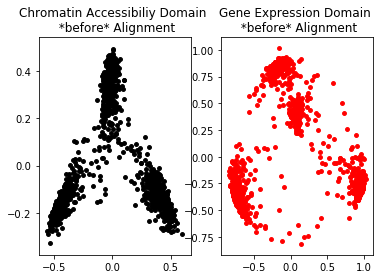

In [8]:
originalX_pca=pca.fit_transform(scot.X)
originaly_pca=pca.fit_transform(scot.y)

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.scatter(originalX_pca[:,0], originalX_pca[:,1], c="k", s=15)
ax1.set_title("Chromatin Accessibiliy Domain \n *before* Alignment")
ax2.scatter(originaly_pca[:,0], originaly_pca[:,1], c="r", s=15)
ax2.set_title("Gene Expression Domain \n *before* Alignment")
plt.show()

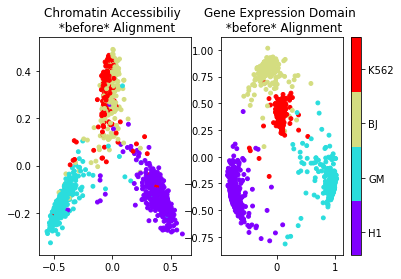

In [9]:
#Visualization of the cell type clusters in original domains *before* alignment
fig, (ax1, ax2)= plt.subplots(1,2)

fig1= ax1.scatter(originalX_pca[:,0], originalX_pca[:,1], c=cellTypes_atac, s=15, cmap=colormap)
ax1.set_title("Chromatin Accessibiliy \n *before* Alignment")

fig2= ax2.scatter(originaly_pca[:,0], originaly_pca[:,1],  c=cellTypes_rna, s=15, cmap=colormap)
ax2.set_title("Gene Expression Domain \n *before* Alignment")

cbar=fig.colorbar(fig2)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(["H1", "GM", "BJ", "K562"]) #cell-type labels